In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

There are a lot of python tutorials about differences in differences. Such as [this](https://towardsdatascience.com/analyze-causal-effect-using-diff-in-diff-model-85e07b17e7b7) or [this](https://www.kaggle.com/code/harrywang/difference-in-differences-in-python/notebook).

This notebook is meant to illustrate how the counterfactual treatment effects on the treatment group are identified using the parallel trends assumption. It uses data from Card and Krueger 1995 to illustrate the concept. Although it is not possible to do pre-trends analysis with only 2 periods, it is still possible to see how the "control" group that is untreated by changes to the minimum wage serves as a counterfactual for the treatment group. The code included in this notebook produces pre-trends plots to demonstrate this concept.

In [2]:
# set up the card and krueger data

dat = pd.read_table('../data/public.dat', sep="\s+", header=None)
dat.columns = ['SHEET','CHAINr','CO_OWNED','STATE','SOUTHJ','CENTRALJ','NORTHJ','PA1','PA2',
               'SHORE','NCALLS','EMPFT','EMPPT','NMGRS','WAGE_ST','INCTIME','FIRSTINC','BONUS',
               'PCTAFF','MEAL','OPEN','HRSOPEN','PSODA','PFRY','PENTREE','NREGS','NREGS11','TYPE2',
               'STATUS2','DATE2','NCALLS2','EMPFT2','EMPPT2','NMGRS2','WAGE_ST2','INCTIME2','FIRSTIN2',
               'SPECIAL2','MEALS2','OPEN2R','HRSOPEN2','PSODA2','PFRY2','PENTREE2','NREGS2','NREGS112']

dat = dat.replace('.', '').apply(pd.to_numeric)
dat['EMPTOT']=dat['EMPPT']*0.5 + dat['EMPFT'] + dat['NMGRS']                                              
dat['EMPTOT2']=dat['EMPPT2']*0.5 + dat['EMPFT2'] + dat['NMGRS2'] 

df_1 = dat[['STATE', 'EMPTOT']]
df_1['t']=0
df_2 = dat[['STATE', 'EMPTOT2']]
df_2['t']=1
df_2.columns = ['STATE', 'EMPTOT','t']
df = pd.concat([df_1, df_2], axis=0)

/tmp/ipykernel_79060/3070256012.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['t']=0
/tmp/ipykernel_79060/3070256012.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['t']=1


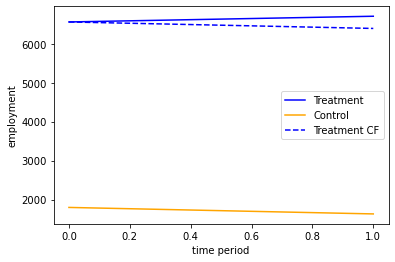

(   t  STATE   EMPTOT
 0  0      0  1796.50
 1  1      0  1629.75,
    t   EMPTOT
 0  0  6561.05
 1  1  6707.75,
    t  STATE   EMPTOT
 0  0      0  6561.05
 1  1      0  6394.30)

In [3]:


def create_plot(data,intervention, begin, end, 
                treat_name = 'STATE',
                time_name = 't',
                y_name = 'EMPTOT'):    
    
    #treatment
    data_treat = data[(data[treat_name]==1) & (data[time_name] >= begin) &
                              (data[time_name] <= end) ][[y_name, time_name]]
    data_treat =  data_treat.groupby(time_name,as_index=False).sum()
    plt.plot(data_treat[time_name],data_treat[y_name],label='Treatment',color='blue')

    
    #control
    data_control  = data[ (data[treat_name]==0) & (data[time_name] >= begin) &
                              (data[time_name] <= end) ]
    data_control =  data_control.groupby(time_name,as_index=False).sum()
    plt.plot(data_control[time_name],data_control[y_name],label='Control',color='orange')
    

    #treat cf
    data_treat_cf = data_control[ (data_control[time_name]>=intervention) & (data_control[time_name]<=end)]
    
    diff = (data_treat[y_name][data_treat[time_name]==intervention].mean() - 
                data_control[y_name][data_control[time_name]==intervention].mean())
    
    data_treat_cf[y_name] = data_treat_cf[y_name] + diff
       
    plt.plot(data_treat_cf[time_name],data_treat_cf[y_name],label='Treatment CF',color='blue',linestyle='--')

    plt.xlabel('time period')
    plt.ylabel('employment')
    plt.legend()
    plt.show()
    return data_control, data_treat, data_treat_cf
    
create_plot(df,0,0,1)